# Weighted MAXCUT Problem

## Problem Statement : 
The [MaxCut problem](https://en.wikipedia.org/wiki/Maximum_cut) is a well-known optimization problem in which the nodes of a given undirected graph have to be divided in two sets (often referred as the set of “white” and “black” nodes) such that the number of edges connecting a white node with a black node are maximized. The MaxCut problem is a problem on which the QAOA algorithm has proved to be useful (for an explanation of the QAOA algorithm you can read [this blogpost](https://www.mustythoughts.com/quantum-approximate-optimization-algorithm-explained)).

At [this link](https://lucaman99.github.io/new_blog/2020/mar16.html) you can find an explicit implementation of the QAOA algorithm to solve the MaxCut problem for the simpler case of an unweighted graph. We ask you to generalize the above code to include also the solution for the case of weighted graphs. You can use the same code or you can also do an alternative implementation using, for example, qiskit. The important point is that you do not make use of any built-in QAOA functionalities.

# Required Installation and Imports

In [ ]:
!pip install pennylane --upgrade

In [54]:
import pennylane as qml
from pennylane import numpy as np

# Test Cases

Each of the test cases here basically represented by three parameters. 

1. n_wires which denotes number of nodes in the graph as well as the number of qubits that  will be used in the quantum circuit. 

2. graph - each element of this list represents each edge of the graph by mentioning the number of two nodes of that edge. 

3. weight - this list contains information about the weights associated with each nodes. 

Importantly, the sequance of edges followed in the 'graph', the same sequence must be followed in the 'weight' too. 

In [ ]:
# n_wires = 3
# graph = [(0,1), (1,2), (0,2)]
# weight = [10, 1, 10]


# n_wires = 4
# graph = [(0, 1), (0, 3), (1, 2), (2, 3)]
# weight = [1, 1, 1, 1]



# n_wires = 5
# graph = [(0,1), (0,2), (1,2), (1,3), (2,3), (3,4)]
# weight = [5, 1, 7, 4, 2, 3]




Test cases written here are commented out because the purpose here is to just show the format we are following to represent the wighted graph. All the test cases has been tested upon in the later section with proper description and visualization. 

# Theoretical Discussion

The main moto of this problem is to seperate the whole set of nodes in two subsets $A$ and $B$ such that the sum of weights of edges that have different types of nodes at their ends become the maximum possible value. 

In other words, we have to find a partition through the whole graph, such that sum of weights of edges that the partition passes becomes the maximum among all possible cuts. 

We can convert this to a simple mathematical expression. 

>>>$C(z) = \sum \limits _{\alpha=1} ^{m} C_{\alpha}(z) $



Here $C(z)$ represents the score of a specific partition through the graph. $\alpha$ iterates from 1 to m where m is the number of edges present. for each edge, $C_{\alpha}(z)$ represents the score associated with each edge. $C_{\alpha}(z)$ is equal to the weight of the edge if the partition passes through that edge and equal to $0$, if not. 



# Representing in terms of Quantum Circuit

As we have already defined a score value for a cut, we have to define that in terms of unitary ooperators that can be implemented on the quantum circuit. 

While representing the partition using computational basis states, we can represent the terms in $C(z)$ as operators acting on the states. 

>>> $C_{\alpha} = \frac{1}{2} W (1-\sigma_z^j \sigma_z^k) $

Here the $\alpha$th edge is the edge connecting $j$th and $k$th nodes. For each node $C_{\alpha}$ will be equal to the weight of the edge if the partition goes between $j$th and $k$th nodes and equal to $0$ if doesn't pass because the operator $(1-\sigma_z^j \sigma_z^k)$ has eigenvalue $1$, iff $j$th and $k$th qubit have different z-axis measurement values. 




Initially the circuit is converted to equal superposition state by applying Hadamard gate in each individual qubit, also known as $|+_{n}>$ state. 

The circuit consists of $L$ layers of $U_B$ and $U_C$ gates. In each layer, one $U_B$ and one $U_C$ is associated with one $\beta$ and $\gamma$ parameter. Therefore each layers having 2 params $\beta$ and $\gamma$, the whole $L$ layered circuit is consist of $2L$ parameters. 

Now coming to each of the layers, $U_B$ is single qubit operator, implemented on each of the individual qubits and it is basically a $R_X$ gate with parameter $2\beta$. $U_C$ whereas acts on two qubits. It is implemented on those two nodes who are connected by an edge in the graph. $U_C$ consists of a $R_Z$ gate with parameter $(-w\gamma)$ sandwitched between two CNOT gates. 

## Defining $U_B$ operator

In [55]:
def U_B(beta):
    for qubit in range(n_wires):
        qml.RX(2*beta, wires=qubit)

## Defining $U_C$ operator

In [58]:
def U_C(gamma):
    for idx in range(n_wires):

        qubit1 = graph[idx][0]
        qubit2 = graph[idx][1]
        w = weight[idx]
        
        qml.CNOT(wires = [qubit1, qubit2])
        qml.RZ((-1)*w*gamma, wires = qubit2)
        qml.CNOT(wires = [qubit1, qubit2])

        

## Computational Basis Measurement

To sample a measurement of multiple qubits in computational basis, we define this Hermitian operator. The eigenvalues of the operator are the qubit measurement values in integer form.

In [ ]:
def comp_basis_measurement(wires):
    n_wires = len(wires)
    return qml.Hermitian(np.diag(range(2 ** n_wires)), wires=wires)

# Creating the circuit

First we are creating a device with wires same as the number of nodes present in the graph

In [ ]:
dev = qml.device("default.qubit", wires=n_wires, analytic=True, shots=1)

We will define a $PauliZ_2$, which will be used to measure the expectatio value at the end of the circuit

In [ ]:
pauliZ = [[1, 0], [0, -1]]

pauliZ_2 = np.kron(pauliZ, pauliZ)

Now the total circuit we will define and call the operators as a function one by one we defined previously. 

Intially the circuit is initialized as zero state on each qubit. 

Then we will apply Hadamard on each qubit to create equal superposition. 

After that $U_C$ and $U_B$ operator will be called $L$ times, where $L$ stands for the number of layers decided. 

Finally, we measure expectation value of each of the edges on the PauliZ_2 basis defined previously. 

In [ ]:
@qml.qnode(dev)
def circuit(gamma, beta, edge=None, layers=1):

    for qubit in range(n_wires):
        qml.Hadamard(wires = qubit)

    for l in range(layers):
        U_C(gamma[l])
        U_B(beta[l])

    if edge is None:
        return qml.sample(comp_basis_measurement(range(n_wires)))

    return qml.expval(qml.Hermitian(pauliZ_2, wires=edge))




**Important - although the device has been initialized and circuit has been defined here for ease of understanding, we will again write the exact same code inside the *optimize_weighted_maxcut()* function later. Bacause each time we implement the code on different graphs with different number of nodes, it requires us to reinitialize the device again with different number of wires within it. So for the ease of implementation we included the *device initialization* and *circuit()* function in the *optimize_weighted_graph()*.**

# Optimization

In [149]:
def optimize_weighted_maxcut(layers = 1):

    dev = qml.device("default.qubit", wires=n_wires, analytic=True, shots=1)

    @qml.qnode(dev)
    def circuit(gamma, beta, edge=None, layers=1):

        for qubit in range(n_wires):
            qml.Hadamard(wires = qubit)

        for l in range(layers):
            U_C(gamma[l])
            U_B(beta[l])

        if edge is None:
            return qml.sample(comp_basis_measurement(range(n_wires)))

        return qml.expval(qml.Hermitian(pauliZ_2, wires=edge))


    print("No of Layers => ", layers)

    init_params = 0.01 * np.random.rand(2, layers)



    def obj_func(params):

        gamma = params[0]
        beta = params[1]

        score = 0
        
        for idx in range(n_wires):
            score -= 0.5 * (1 - weight[idx] * circuit(gamma, beta, edge=graph[idx], layers=layers))

        return score

    optimizer = qml.AdagradOptimizer(stepsize = 0.5)

    params = init_params

    n_iters = 120

    for iter in range(n_iters):
        params = optimizer.step(obj_func, params)

        if ((iter+1)%10 == 0):
            print ("Score after step {} => {: .7f}".format(iter+1, (-1)*obj_func(params)))

    n_samples = 100
    bit_strings = []

    for i in range(n_samples):
        gamma = params[0]
        beta = params[1]
        bit_string = int(circuit(gamma, beta, 
                                 edge = None, 
                                 layers = layers))
        bit_strings.append(bit_string)

        
    counts = np.bincount(np.array(bit_strings))
    most_freq_bit_string = np.argmax(counts)

    print("Optimized (gamma, beta) parameters:\n{}".format(params[:, :layers]))
    print("Most frequently sampled bit string is: {:05b}".format(most_freq_bit_string))
    print("\n\n")

    return ((-1)*obj_func(params), bit_strings)

# Test cases

### Some important notation and color coding used in the graph representation

Intially the unpartitioned graphs are drawn in $Black$ and $white$ only with node identity and weights of edges written on each node and edge respectively. 

The partitioned graph is represented with various $colors$ for the each of understanding. The $Blue$ colored curved line with an $arrow$ in one end shows the partion on the graph. All the edges cut by that partition is shown in $Red$ color and rest of the edges are in $Black$. After partitioning, the nodes are divided into two sets, which are shown in $Green$ and $Purple$ respectively. 


***Important - For all the test cases, various no. of layers circuit has been tried while experimenting but here only the least one with considerable accuracy has been shown only***

## Test Case 1

This graph consists of three nodes and three edges, among which two edges have weights 10 and other one has weight 1. 

In [132]:
n_wires = 3
graph = [(0,1), (1,2), (0,2)]
weight = [10.0, 1.0, 10.0]


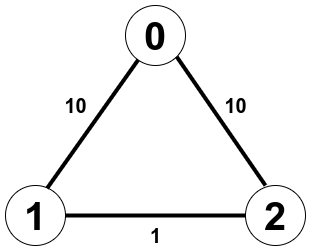

In [133]:
result_layer_1 = optimize_weighted_maxcut(layers = 1)

No of Layers =>  1
Score after step 10 =>  2.4797634
Score after step 20 =>  9.1759125
Score after step 30 =>  8.0713701
Score after step 40 =>  8.8986986
Score after step 50 =>  9.3450827
Score after step 60 =>  9.5212575
Score after step 70 =>  9.5885819
Score after step 80 =>  9.6141117
Score after step 90 =>  9.6237942
Score after step 100 =>  9.6274740
Optimized (gamma, beta) parameters:
[[-0.51495025]
 [ 0.47558505]]
Most frequently sampled bit string is: 011





In [134]:
result_layer_2 = optimize_weighted_maxcut(layers = 2)

No of Layers =>  2
Score after step 10 =>  0.4727220
Score after step 20 =>  6.4969871
Score after step 30 =>  5.9274456
Score after step 40 =>  9.9780548
Score after step 50 =>  10.0460350
Score after step 60 =>  10.8916321
Score after step 70 =>  9.1070196
Score after step 80 =>  9.8131832
Score after step 90 =>  10.1673002
Score after step 100 =>  10.3832345
Optimized (gamma, beta) parameters:
[[ 0.50766728  0.50355068]
 [ 0.98714894 -0.23554857]]
Most frequently sampled bit string is: 100





In [135]:
result_layer_3 = optimize_weighted_maxcut(layers = 3)

No of Layers =>  3
Score after step 10 => -0.2791099
Score after step 20 =>  5.5789787
Score after step 30 =>  8.7584667
Score after step 40 =>  10.5815141
Score after step 50 =>  6.7752574
Score after step 60 =>  9.7616467
Score after step 70 =>  10.6443366
Score after step 80 =>  10.7156089
Score after step 90 =>  10.3284025
Score after step 100 =>  10.6094188
Optimized (gamma, beta) parameters:
[[-0.48352685  1.4282914  -0.77671925]
 [ 2.05997777  1.83025401  1.58612476]]
Most frequently sampled bit string is: 100





In [136]:
result_layer_4 = optimize_weighted_maxcut(layers = 4)

No of Layers =>  4
Score after step 10 =>  4.4964044
Score after step 20 =>  3.8729146
Score after step 30 =>  0.5777400
Score after step 40 =>  5.0608794
Score after step 50 =>  4.0889390
Score after step 60 =>  10.3367572
Score after step 70 =>  10.5984392
Score after step 80 =>  10.8834443
Score after step 90 =>  10.9695065
Score after step 100 =>  10.9489615
Optimized (gamma, beta) parameters:
[[-0.51352681 -0.06623642  0.43008821  0.71881128]
 [-1.03632732 -0.2169661   1.31175744  1.57835043]]
Most frequently sampled bit string is: 011





In [137]:
result_layer_5 = optimize_weighted_maxcut(layers = 5)

No of Layers =>  5
Score after step 10 =>  6.7615399
Score after step 20 => -0.5859293
Score after step 30 =>  3.5717466
Score after step 40 =>  1.7938380
Score after step 50 =>  5.1021564
Score after step 60 =>  0.6139162
Score after step 70 =>  5.0943986
Score after step 80 =>  9.6086891
Score after step 90 =>  5.5025918
Score after step 100 =>  10.1882682
Optimized (gamma, beta) parameters:
[[ 0.04846837  1.09042769  0.51745129  2.06096913  0.71804306]
 [ 3.36812843 -0.50504909  0.56140218 -0.53005832  1.1487762 ]]
Most frequently sampled bit string is: 100





In [138]:
result_layer_6 = optimize_weighted_maxcut(layers = 6)

No of Layers =>  6
Score after step 10 => -4.4704693
Score after step 20 =>  3.3008123
Score after step 30 =>  3.3942894
Score after step 40 =>  2.2386935
Score after step 50 =>  3.3382820
Score after step 60 =>  10.6680362
Score after step 70 =>  10.8392712
Score after step 80 =>  10.9627772
Score after step 90 =>  10.9915360
Score after step 100 =>  10.9977354
Optimized (gamma, beta) parameters:
[[ 0.51087248  0.54583004  1.18093458  0.65904417  2.07830181  1.42846805]
 [-0.47453707  1.48252868 -0.09618956  0.00839618  0.1246405   1.70151027]]
Most frequently sampled bit string is: 100





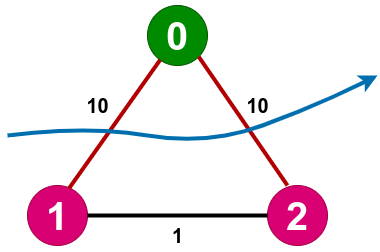

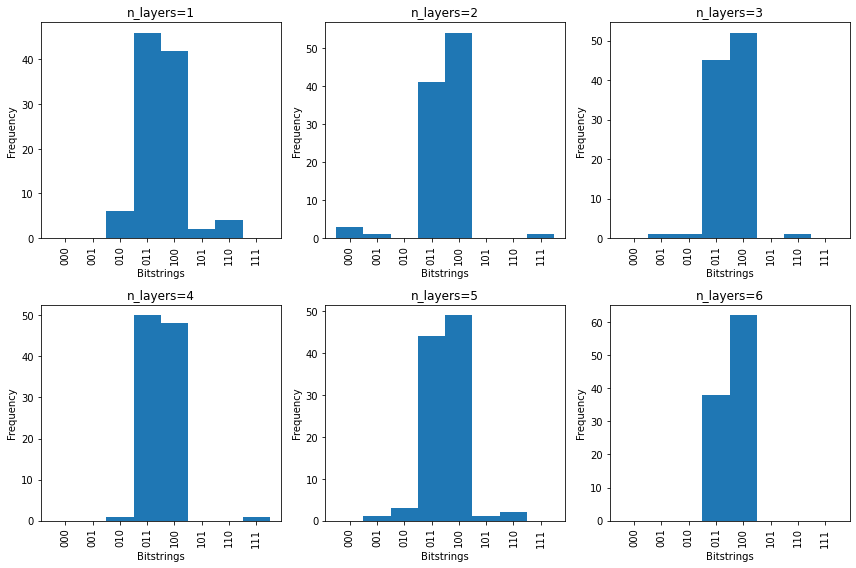

In [139]:
import matplotlib.pyplot as plt

xticks = range(0, 8)
xtick_labels = list(map(lambda x: format(x, "03b"), xticks))
bins = np.arange(0, 9) - 0.5

fig, (ax1, ax2) = plt.subplots(2, 3, figsize=(12, 8))

plt.subplot(2, 3, 1)
plt.title("n_layers=1")
plt.xlabel("Bitstrings")
plt.ylabel("Frequency")
plt.xticks(xticks, xtick_labels, rotation="vertical")
plt.hist(result_layer_1[1], bins=bins)

plt.subplot(2, 3, 2)
plt.title("n_layers=2")
plt.xlabel("Bitstrings")
plt.ylabel("Frequency")
plt.xticks(xticks, xtick_labels, rotation="vertical")
plt.hist(result_layer_2[1], bins=bins)

plt.subplot(2, 3, 3)
plt.title("n_layers=3")
plt.xlabel("Bitstrings")
plt.ylabel("Frequency")
plt.xticks(xticks, xtick_labels, rotation="vertical")
plt.hist(result_layer_3[1], bins=bins)

plt.subplot(2, 3, 4)
plt.title("n_layers=4")
plt.xlabel("Bitstrings")
plt.ylabel("Frequency")
plt.xticks(xticks, xtick_labels, rotation="vertical")
plt.hist(result_layer_4[1], bins=bins)

plt.subplot(2, 3, 5)
plt.title("n_layers=5")
plt.xlabel("Bitstrings")
plt.ylabel("Frequency")
plt.xticks(xticks, xtick_labels, rotation="vertical")
plt.hist(result_layer_5[1], bins=bins)

plt.subplot(2, 3, 6)
plt.title("n_layers=6")
plt.xlabel("Bitstrings")
plt.ylabel("Frequency")
plt.xticks(xticks, xtick_labels, rotation="vertical")
plt.hist(result_layer_6[1], bins=bins)

plt.tight_layout()
plt.show()

*Conclusion - Here the MAXCUT solution is quite simple and sum of weiights of cut edges is $(10+10)=20$*

## Test case 2

This test case although shown as weighted graph, is basically a unweighted grpah and the all weights are set to $1$ to make fir as input to this solution. 

This graph I tried to check how general the solution is. 

In [141]:
n_wires = 4
graph = [(0, 1), (0, 3), (1, 2), (2, 3)]
weight = [1.0, 1.0, 1.0, 1.0]


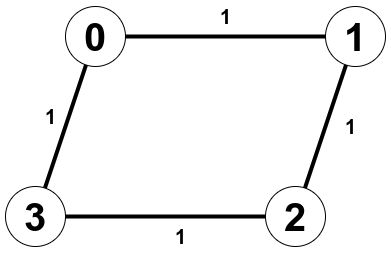

In [142]:
result_layer_1 = optimize_weighted_maxcut(layers = 1)

No of Layers =>  1
Score after step 10 =>  2.9956645
Score after step 20 =>  2.9999166
Score after step 30 =>  2.9999985
Score after step 40 =>  3.0000000
Score after step 50 =>  3.0000000
Score after step 60 =>  3.0000000
Score after step 70 =>  3.0000000
Score after step 80 =>  3.0000000
Score after step 90 =>  3.0000000
Score after step 100 =>  3.0000000
Optimized (gamma, beta) parameters:
[[0.78539816]
 [0.39269908]]
Most frequently sampled bit string is: 0101





In [143]:
result_layer_2 = optimize_weighted_maxcut(layers = 2)

No of Layers =>  2
Score after step 10 =>  3.6912500
Score after step 20 =>  3.9885669
Score after step 30 =>  3.9994616
Score after step 40 =>  3.9999610
Score after step 50 =>  3.9999969
Score after step 60 =>  3.9999998
Score after step 70 =>  4.0000000
Score after step 80 =>  4.0000000
Score after step 90 =>  4.0000000
Score after step 100 =>  4.0000000
Optimized (gamma, beta) parameters:
[[ 1.57079633  0.78539816]
 [ 0.39269861 -0.78539872]]
Most frequently sampled bit string is: 1010





In [144]:
result_layer_3 = optimize_weighted_maxcut(layers = 3)

No of Layers =>  3
Score after step 10 =>  3.5018042
Score after step 20 =>  3.9944599
Score after step 30 =>  3.9999053
Score after step 40 =>  3.9999983
Score after step 50 =>  4.0000000
Score after step 60 =>  4.0000000
Score after step 70 =>  4.0000000
Score after step 80 =>  4.0000000
Score after step 90 =>  4.0000000
Score after step 100 =>  4.0000000
Optimized (gamma, beta) parameters:
[[ 0.18183474  1.31229444  0.92066122]
 [-0.21731856  0.4112965  -0.79900026]]
Most frequently sampled bit string is: 1010





In [145]:
result_layer_4 = optimize_weighted_maxcut(layers = 4)

No of Layers =>  4
Score after step 10 =>  3.6936956
Score after step 20 =>  3.8777493
Score after step 30 =>  3.9388511
Score after step 40 =>  3.9849195
Score after step 50 =>  3.9964682
Score after step 60 =>  3.9991839
Score after step 70 =>  3.9998120
Score after step 80 =>  3.9999567
Score after step 90 =>  3.9999900
Score after step 100 =>  3.9999977
Optimized (gamma, beta) parameters:
[[-0.40280255 -0.1035949  -1.09822589  0.42692074]
 [ 0.4597881   0.79539967  0.52227808  0.63591589]]
Most frequently sampled bit string is: 1010





In [146]:
result_layer_5 = optimize_weighted_maxcut(layers = 5)

No of Layers =>  5
Score after step 10 =>  3.7011971
Score after step 20 =>  3.3334335
Score after step 30 =>  3.8302122
Score after step 40 =>  3.9620657
Score after step 50 =>  3.9920654
Score after step 60 =>  3.9983602
Score after step 70 =>  3.9996614
Score after step 80 =>  3.9999300
Score after step 90 =>  3.9999855
Score after step 100 =>  3.9999970
Optimized (gamma, beta) parameters:
[[ 0.69176461  0.69785337 -0.27151457  0.29827006  1.83971143]
 [ 0.49032089  0.83513925  0.72936732  0.3247222  -0.01025179]]
Most frequently sampled bit string is: 0101





In [147]:
result_layer_6 = optimize_weighted_maxcut(layers = 6)

No of Layers =>  6
Score after step 10 =>  1.6438418
Score after step 20 =>  3.5112701
Score after step 30 =>  3.5665843
Score after step 40 =>  3.8530393
Score after step 50 =>  3.9480861
Score after step 60 =>  3.9616875
Score after step 70 =>  3.9360302
Score after step 80 =>  3.9698976
Score after step 90 =>  3.9964561
Score after step 100 =>  3.9996051
Optimized (gamma, beta) parameters:
[[ 0.77437563  1.33604715 -0.23851299  0.28037391  0.20348283  0.49067582]
 [ 0.54233106 -0.16339663  0.67443918 -0.23750557  0.20107031 -0.00634532]]
Most frequently sampled bit string is: 1010





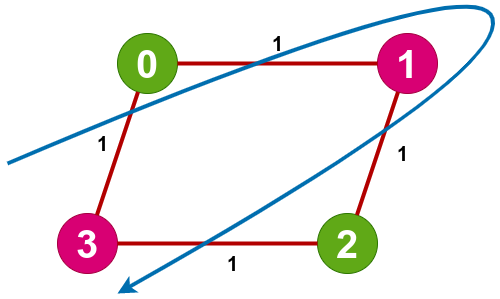

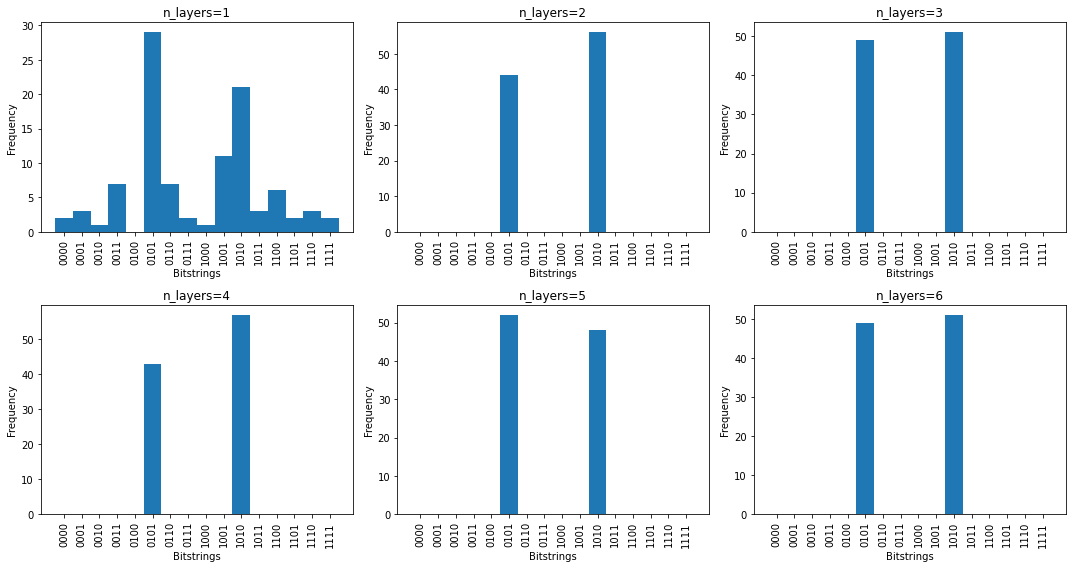

In [148]:
import matplotlib.pyplot as plt

xticks = range(0, 16)
xtick_labels = list(map(lambda x: format(x, "04b"), xticks))
bins = np.arange(0, 17) - 0.5

fig, (ax1, ax2) = plt.subplots(2, 3, figsize=(15, 8))

plt.subplot(2, 3, 1)
plt.title("n_layers=1")
plt.xlabel("Bitstrings")
plt.ylabel("Frequency")
plt.xticks(xticks, xtick_labels, rotation="vertical")
plt.hist(result_layer_1[1], bins=bins)

plt.subplot(2, 3, 2)
plt.title("n_layers=2")
plt.xlabel("Bitstrings")
plt.ylabel("Frequency")
plt.xticks(xticks, xtick_labels, rotation="vertical")
plt.hist(result_layer_2[1], bins=bins)

plt.subplot(2, 3, 3)
plt.title("n_layers=3")
plt.xlabel("Bitstrings")
plt.ylabel("Frequency")
plt.xticks(xticks, xtick_labels, rotation="vertical")
plt.hist(result_layer_3[1], bins=bins)

plt.subplot(2, 3, 4)
plt.title("n_layers=4")
plt.xlabel("Bitstrings")
plt.ylabel("Frequency")
plt.xticks(xticks, xtick_labels, rotation="vertical")
plt.hist(result_layer_4[1], bins=bins)

plt.subplot(2, 3, 5)
plt.title("n_layers=5")
plt.xlabel("Bitstrings")
plt.ylabel("Frequency")
plt.xticks(xticks, xtick_labels, rotation="vertical")
plt.hist(result_layer_5[1], bins=bins)

plt.subplot(2, 3, 6)
plt.title("n_layers=6")
plt.xlabel("Bitstrings")
plt.ylabel("Frequency")
plt.xticks(xticks, xtick_labels, rotation="vertical")
plt.hist(result_layer_6[1], bins=bins)

plt.tight_layout()
plt.show()

*Conclusion - The partition passes through all four edges present in the graph. Sum of weights herre is $4$ which is the maximum possible value*

## Test Case 3

This one is the most complex among all three cases. It consists of $5$ nodes numbered from $0$ - $4$ and $6$ edges connecting them, with the weights written on them. 

In [118]:
n_wires = 5
graph = [(0,1), (0,2), (1,2), (1,3), (2,3), (3,4)]
weight = [5.0, 1.0, 7.0, 4.0, 2.0, 3.0]


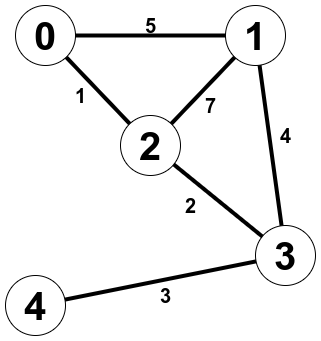

In [119]:
result_layer_1 = optimize_weighted_maxcut(layers = 1)

No of Layers =>  1
Score after step 10 =>  4.3800390
Score after step 20 =>  5.3163004
Score after step 30 =>  5.7963822
Score after step 40 =>  5.9514917
Score after step 50 =>  6.0351685
Score after step 60 =>  6.0779533
Score after step 70 =>  6.0979146
Score after step 80 =>  6.1068242
Score after step 90 =>  6.1107153
Score after step 100 =>  6.1123958
Score after step 110 =>  6.1131171
Score after step 120 =>  6.1134257
Score after step 130 =>  6.1135575
Score after step 140 =>  6.1136137
Score after step 150 =>  6.1136376
Optimized (gamma, beta) parameters:
[[-0.1382598 ]
 [ 1.23094463]]
Most frequently sampled bit string is: 01001





In [121]:
result_layer_3 = optimize_weighted_maxcut(layers = 3)

No of Layers =>  3
Score after step 10 =>  7.1054461
Score after step 20 =>  6.8896493
Score after step 30 =>  7.3562312
Score after step 40 =>  7.4560344
Score after step 50 =>  7.7669496
Score after step 60 =>  7.8991281
Score after step 70 =>  7.9415296
Score after step 80 =>  7.9953969
Score after step 90 =>  8.0017844
Score after step 100 =>  8.0275944
Score after step 110 =>  8.0400097
Score after step 120 =>  8.0518342
Score after step 130 =>  8.0613125
Score after step 140 =>  8.0694624
Score after step 150 =>  8.0766313
Optimized (gamma, beta) parameters:
[[ 0.34586831  1.28283133  1.52644187]
 [ 1.33227121 -0.69862921 -0.16744012]]
Most frequently sampled bit string is: 01001





In [123]:
result_layer_5 = optimize_weighted_maxcut(layers = 5)

No of Layers =>  5
Score after step 10 =>  2.0743686
Score after step 20 =>  5.5711036
Score after step 30 =>  8.2786905
Score after step 40 =>  8.1051138
Score after step 50 =>  8.2275897
Score after step 60 =>  8.1844176
Score after step 70 =>  8.4400342
Score after step 80 =>  8.5336292
Score after step 90 =>  8.7101701
Score after step 100 =>  8.7069727
Score after step 110 =>  8.7064993
Score after step 120 =>  8.7679418
Score after step 130 =>  8.7894423
Score after step 140 =>  8.7970058
Score after step 150 =>  8.8043079
Optimized (gamma, beta) parameters:
[[ 0.53842075  0.37209072  0.40984162  0.89311992 -0.9830643 ]
 [-0.39919495  0.08429728  0.99668837  0.68668371  1.27323657]]
Most frequently sampled bit string is: 10110





In [126]:
result_layer_8 = optimize_weighted_maxcut(layers = 8)

No of Layers =>  8
Score after step 10 =>  6.0257240
Score after step 20 =>  2.9071833
Score after step 30 =>  0.7444076
Score after step 40 =>  1.9317052
Score after step 50 =>  7.3203772
Score after step 60 =>  7.6763419
Score after step 70 =>  7.5582520
Score after step 80 =>  7.6809170
Score after step 90 =>  8.0341842
Score after step 100 =>  7.0237230
Score after step 110 =>  8.0191135
Score after step 120 =>  7.6246022
Score after step 130 =>  7.8245391
Score after step 140 =>  8.0093226
Score after step 150 =>  8.0491182
Optimized (gamma, beta) parameters:
[[ 2.02073914  0.29417432  0.53746804 -0.3245672   0.77304782  1.77142865
   0.61693498  0.65861972]
 [ 0.8281189  -0.40411806  2.10811165  1.24726064 -0.45933673  1.43481017
   0.03447598  1.47242451]]
Most frequently sampled bit string is: 10110





In [127]:
result_layer_9 = optimize_weighted_maxcut(layers = 9)

No of Layers =>  9
Score after step 10 =>  5.1130952
Score after step 20 =>  3.9209312
Score after step 30 =>  3.6271838
Score after step 40 =>  4.2990644
Score after step 50 =>  2.6038379
Score after step 60 =>  4.3142722
Score after step 70 =>  5.1789440
Score after step 80 =>  7.1693157
Score after step 90 =>  6.6584993
Score after step 100 =>  8.7497379
Score after step 110 =>  7.7359145
Score after step 120 =>  8.7751609
Score after step 130 =>  8.6327298
Score after step 140 =>  8.8844299
Score after step 150 =>  8.3373766
Optimized (gamma, beta) parameters:
[[ 2.63820647  2.69303682  0.29542615  0.84757425 -0.94520516 -0.12372252
  -0.9692197  -1.07552769 -0.95289776]
 [ 1.6664731  -0.37204722  0.33235321  0.20483272  1.91878679  1.02063629
   0.3357627   0.35898522 -1.03619348]]
Most frequently sampled bit string is: 10110





In [128]:
result_layer_10 = optimize_weighted_maxcut(layers = 10)

No of Layers =>  10
Score after step 10 =>  3.3837316
Score after step 20 =>  1.8066665
Score after step 30 =>  0.6113653
Score after step 40 =>  7.0679550
Score after step 50 =>  4.1026325
Score after step 60 =>  1.9974331
Score after step 70 =>  5.8614750
Score after step 80 =>  7.0101827
Score after step 90 =>  7.7959242
Score after step 100 =>  8.0664529
Score after step 110 =>  8.2571389
Score after step 120 =>  8.6954168
Score after step 130 =>  8.6277719
Score after step 140 =>  8.8778459
Score after step 150 =>  8.9444203
Optimized (gamma, beta) parameters:
[[ 0.48517152  0.19563172  1.05039036  0.768665    0.22495292  0.27938135
   0.47336257  0.76199222  1.58149956  1.33157646]
 [ 1.06093084 -0.16125032  0.01119344  1.17667013  0.72361957  1.05409722
   0.82968154 -1.25596129  1.03677826  0.81137222]]
Most frequently sampled bit string is: 01001





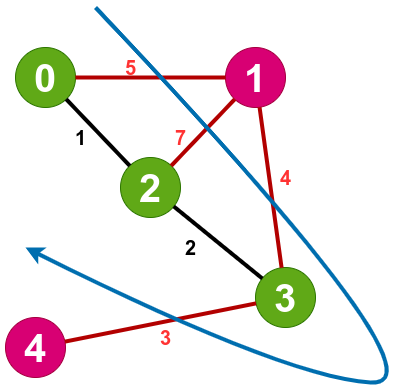

*Conclusion - In this test case, the solution partition passes through $4$ out of $6$ edges, summing the weights to $(5+7+4+3) = 19$*

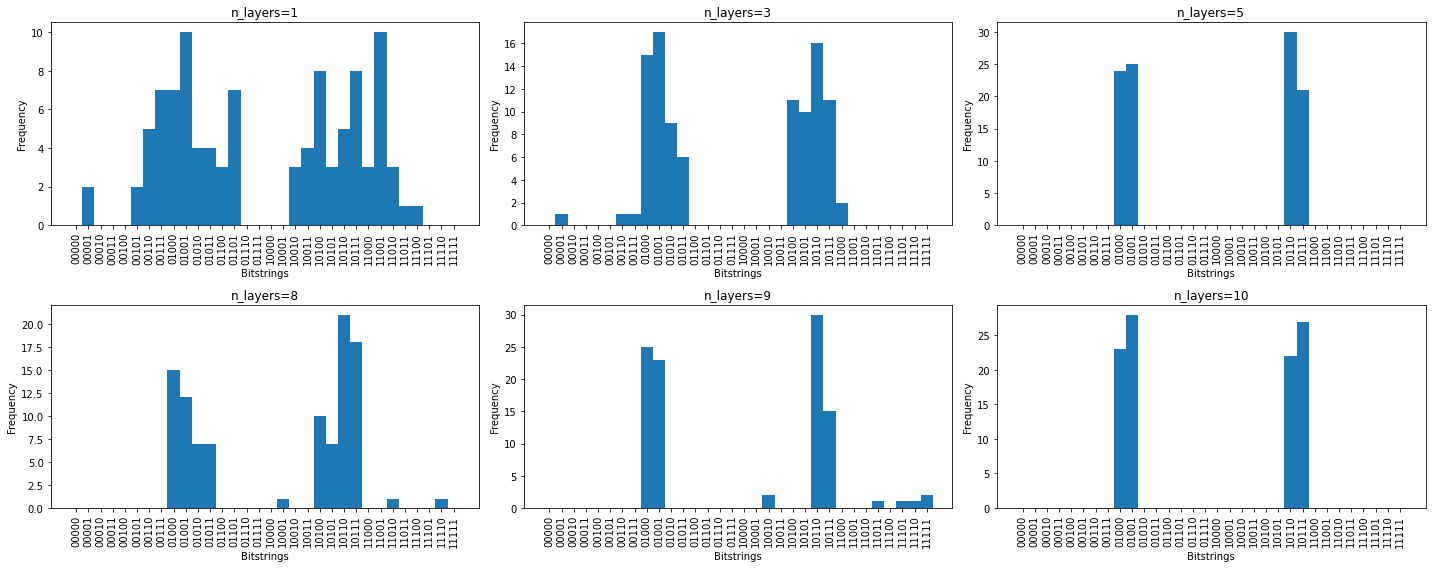

In [129]:
import matplotlib.pyplot as plt

xticks = range(0, 32)
xtick_labels = list(map(lambda x: format(x, "05b"), xticks))
bins = np.arange(0, 33) - 0.5

fig, (ax1, ax2) = plt.subplots(2, 3, figsize=(20, 8))

plt.subplot(2, 3, 1)
plt.title("n_layers=1")
plt.xlabel("Bitstrings")
plt.ylabel("Frequency")
plt.xticks(xticks, xtick_labels, rotation="vertical")
plt.hist(result_layer_1[1], bins=bins)

plt.subplot(2, 3, 2)
plt.title("n_layers=3")
plt.xlabel("Bitstrings")
plt.ylabel("Frequency")
plt.xticks(xticks, xtick_labels, rotation="vertical")
plt.hist(result_layer_3[1], bins=bins)

plt.subplot(2, 3, 3)
plt.title("n_layers=5")
plt.xlabel("Bitstrings")
plt.ylabel("Frequency")
plt.xticks(xticks, xtick_labels, rotation="vertical")
plt.hist(result_layer_5[1], bins=bins)

plt.subplot(2, 3, 4)
plt.title("n_layers=8")
plt.xlabel("Bitstrings")
plt.ylabel("Frequency")
plt.xticks(xticks, xtick_labels, rotation="vertical")
plt.hist(result_layer_8[1], bins=bins)

plt.subplot(2, 3, 5)
plt.title("n_layers=9")
plt.xlabel("Bitstrings")
plt.ylabel("Frequency")
plt.xticks(xticks, xtick_labels, rotation="vertical")
plt.hist(result_layer_9[1], bins=bins)

plt.subplot(2, 3, 6)
plt.title("n_layers=10")
plt.xlabel("Bitstrings")
plt.ylabel("Frequency")
plt.xticks(xticks, xtick_labels, rotation="vertical")
plt.hist(result_layer_10[1], bins=bins)

plt.tight_layout()
plt.show()